# libraries

In [1]:
import numpy as np
import gensim
import pandas as pd
from pandas.api.types import is_numeric_dtype
import tensorflow as tf
from tensorflow import keras
from getEmb import Word2vec
import sklearn
from sklearn import *
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# auxiliary functions

In [2]:
def train_test_by_label(data, labels_position=0, seed=42, test_size=0.2):

    labels = data.iloc[:, labels_position]
    unique_labels = labels.unique()

    # shuffle activities
    rng = np.random.RandomState(seed)
    rng.shuffle(unique_labels)

    # split activities in train and test
    test_dim = int(test_size * len(unique_labels))
    unique_labels_train = unique_labels[:-test_dim]
    unique_labels_test = unique_labels[-test_dim:]

    # split df in train and test based on activity
    train = data[data.iloc[:, labels_position].isin(unique_labels_train)]
    test = data[data.iloc[:, labels_position].isin(unique_labels_test)]

    # shuffle records
    train = train.sample(frac=1)
    test = test.sample(frac=1)

    # split in features and labels
    X_train = train.iloc[:, 1:]
    y_train = train.iloc[:, 0]
    X_test = test.iloc[:, 1:]
    y_test = test.iloc[:, 0]

    return X_train, y_train, X_test, y_test

def closest_to_predictions(predictions, emb_unique):
    preds = list()
    for pred in predictions:
        # list of distances between embedded prediction and embedded words
        D = list()
        for e in emb_unique:
            D.append(sklearn.metrics.pairwise.euclidean_distances(pred.reshape(1, -1), e.reshape(1, -1)))
        # index of minimum distance
        v = tf.math.argmin(D)
        # revised prediction: actual word or average of words that is closest to model prediction
        preds.append(emb_unique[tuple(v)])
    preds = np.array(preds)
    return preds.reshape(preds.shape[0], preds.shape[2])

# takes the embedded words (the output of closest_embedded) and returns its actual word
def reverse_embedding(y, emb, to_revert):
    y = pd.DataFrame(y).reset_index().drop(columns='index')
    emb = pd.DataFrame(np.mean(emb, axis=1), columns=['emb_mean'])
    word_embedded_link = y.merge(emb, how='outer', left_index=True, right_index=True)
    word_embedded_link = word_embedded_link.drop_duplicates()
    closest_mean = pd.DataFrame(np.mean(to_revert, axis=1))
    closest_mean.columns = ['mean']
    return closest_mean.merge(word_embedded_link, how='left', left_on='mean', right_on='emb_mean')[0]

def model_evaluation(true, pred):
    print('\nModel accuracy is: \n', sklearn.metrics.accuracy_score(true, pred))
    print('\nModel precision is: \n', sklearn.metrics.precision_score(true, pred, average='macro', zero_division=1))
    print('\nModel recall is: \n', sklearn.metrics.recall_score(true, pred, average='macro', zero_division=1))
    print('\nModel F1 measure is: \n', sklearn.metrics.f1_score(true, pred, average='macro', zero_division=1))
    print('\nConfusion Matrix:\n')
    cm = sklearn.metrics.confusion_matrix(true, pred, labels=np.unique(y_test))
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(xticks_rotation='vertical')
    
def pick_test_classes(data, test_classes):
    test = data[data['Activity'].isin(test_classes)]
    train = data[~data['Activity'].isin(test_classes)]
    # shuffle records
    train = train.sample(frac=1)
    test = test.sample(frac=1)
    # split in features and labels
    X_train = train.iloc[:, 1:]
    y_train = train.iloc[:, 0]
    X_test = test.iloc[:, 1:]
    y_test = test.iloc[:, 0]
    return X_train, y_train, X_test, y_test

In [3]:
# word embedder
embedder = Word2vec()

# baseline

Number of words  : 2707
Number of words  : 524
Epoch 1/15
85/85 - 0s - loss: 2.9349
Epoch 2/15
85/85 - 0s - loss: 1.0144
Epoch 3/15
85/85 - 0s - loss: 0.7773
Epoch 4/15
85/85 - 0s - loss: 0.6177
Epoch 5/15
85/85 - 0s - loss: 0.5404
Epoch 6/15
85/85 - 0s - loss: 0.4850
Epoch 7/15
85/85 - 0s - loss: 0.4459
Epoch 8/15
85/85 - 0s - loss: 0.4113
Epoch 9/15
85/85 - 0s - loss: 0.3814
Epoch 10/15
85/85 - 0s - loss: 0.3579
Epoch 11/15
85/85 - 0s - loss: 0.3369
Epoch 12/15
85/85 - 0s - loss: 0.3179
Epoch 13/15
85/85 - 0s - loss: 0.3005
Epoch 14/15
85/85 - 0s - loss: 0.2857
Epoch 15/15
85/85 - 0s - loss: 0.2712

Evaluation:
17/17 [==============================] - 0s 999us/step - loss: 0.3173

Model accuracy is: 
 0.36450381679389315

Model precision is: 
 0.7271273192578375

Model recall is: 
 0.17

Model F1 measure is: 
 0.09526834207861547

Confusion Matrix:



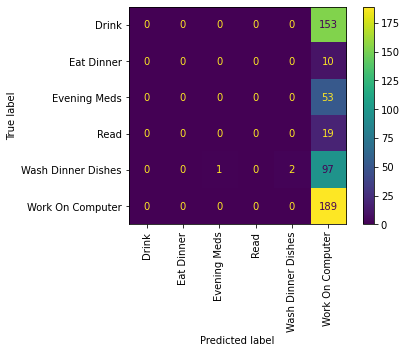

In [4]:
# import
data = pd.read_csv('Features.csv')
# split
X_train, y_train, X_test, y_test = train_test_by_label(data)
# turn into ndarrays for tf
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# introductory model as per specifications
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
outputs = keras.layers.Dense(300, activation="linear", kernel_regularizer='l2', name="predictions")(inputs)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.SGD(), loss='mse')
model.fit(X_train, emb_train, epochs=15, verbose=2, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# so the model doesn't make good predictions. Let's explore the data and come up with improvements.

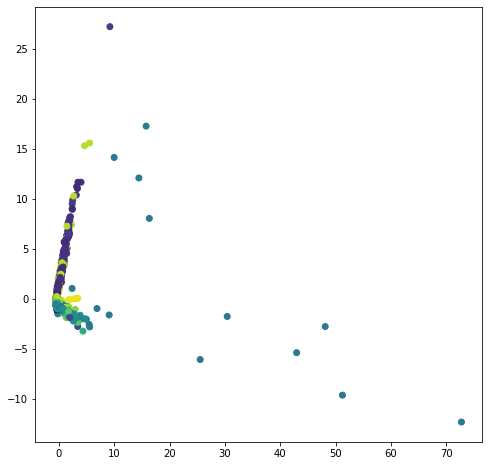

In [5]:
# PCA 2 components to visualize the distribution
X_train_standard = sklearn.preprocessing.StandardScaler().fit_transform(X_train)
pca = sklearn.decomposition.PCA(n_components=2)
PC = pca.fit_transform(X_train_standard)
# encode labels
le = sklearn.preprocessing.LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# visualize
fig = plt.figure(figsize=(8,8))
plt.scatter(PC[:, 0], PC[:, 1], c=y_train_encoded)

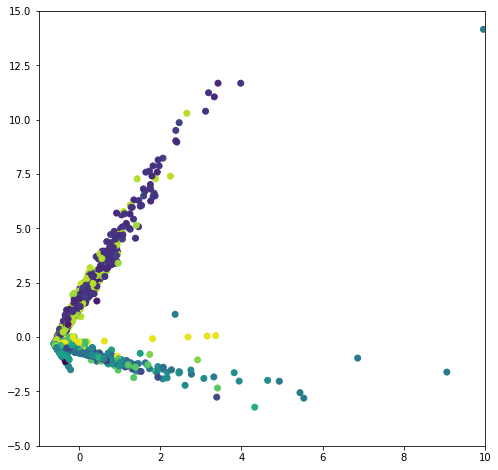

In [6]:
#let's take a closer look
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(PC[:, 0], PC[:, 1], c=y_train_encoded)
ax.set(xlim=(-1, 10), ylim=(-5, 15))
plt.show()

In [7]:
# predictions are particularly poor, let's analyze and process the data to make them easier to generalize
data.describe()

,D001,D002,D003,M001,M002,M003,M004,M005,M006,M007,...,M015,M016,M017,MA018,MA019,MA020,MA021,MA022,MA023,MA024
count,3231.0,3231.000000,3231.0,3231.000000,3231.000000,3231.000000,3231.000000,3231.0,3231.0,3231.000000,...,3231.00000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.0,3231.0
mean,0.0,0.166512,0.0,0.170845,0.460229,0.408233,0.051068,0.0,0.0,2.492108,...,1.44104,0.059115,6.794491,0.082637,0.767564,6.099969,0.791705,0.507583,0.0,0.0
std,0.0,0.426091,0.0,1.401204,2.215946,2.572933,0.852346,0.0,0.0,10.345899,...,8.44594,1.751046,22.628290,1.342671,4.853853,16.225069,4.302164,1.777009,0.0,0.0
min,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,...,0.00000,0.000000,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,0.0
max,0.0,6.000000,0.0,43.000000,45.000000,84.000000,38.000000,0.0,0.0,382.000000,...,235.00000,87.000000,597.000000,37.000000,150.000000,205.000000,126.000000,23.000000,0.0,0.0


In [8]:
data.groupby('Activity').count().iloc[:, 0]

Activity
Bath                      25
Bed Toilet Transition     29
Cook                      19
Cook Breakfast            78
Cook Dinner              234
Cook Lunch                65
Dress                    212
Drink                    153
Eat                        5
Eat Breakfast             11
Eat Dinner                10
Eat Lunch                  8
Enter Home               234
Entertain Guests          21
Evening Meds              53
Groom                    197
Leave Home               235
Morning Meds              51
Personal Hygiene         219
Phone                     57
Read                      19
Relax                      9
Sleep                     95
Sleep Out Of Bed          83
Step Out                  33
Take Medicine             35
Toilet                   258
Wash Breakfast Dishes     66
Wash Dinner Dishes       100
Wash Dishes              154
Wash Lunch Dishes         28
Watch TV                 218
Work                      28
Work On Computer         189
Name:

In [9]:
# let's check evident patterns between features
data.groupby('Activity').mean().round().sort_values(by='MA022', ascending=False)

,D001,D002,D003,M001,M002,M003,M004,M005,M006,M007,...,M015,M016,M017,MA018,MA019,MA020,MA021,MA022,MA023,MA024
Activity,,,,,,,,,,,,,,,,,,,,,
Cook Breakfast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,...,0.0,0.0,30.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
Cook Lunch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,1.0,0.0,35.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
Entertain Guests,0.0,1.0,0.0,11.0,6.0,19.0,5.0,0.0,0.0,35.0,...,50.0,9.0,76.0,8.0,16.0,20.0,15.0,3.0,0.0,0.0
Cook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,21.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
Cook Dinner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,1.0,0.0,31.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
Wash Dishes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,...,0.0,0.0,26.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Drink,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Wash Lunch Dishes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Wash Dinner Dishes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# remove empty cols

Number of words  : 2707
Number of words  : 524
Epoch 1/15
85/85 - 0s - loss: 2.5529
Epoch 2/15
85/85 - 0s - loss: 0.8625
Epoch 3/15
85/85 - 0s - loss: 0.5951
Epoch 4/15
85/85 - 0s - loss: 0.4636
Epoch 5/15
85/85 - 0s - loss: 0.3868
Epoch 6/15
85/85 - 0s - loss: 0.3303
Epoch 7/15
85/85 - 0s - loss: 0.2938
Epoch 8/15
85/85 - 0s - loss: 0.2626
Epoch 9/15
85/85 - 0s - loss: 0.2372
Epoch 10/15
85/85 - 0s - loss: 0.2185
Epoch 11/15
85/85 - 0s - loss: 0.1989
Epoch 12/15
85/85 - 0s - loss: 0.1839
Epoch 13/15
85/85 - 0s - loss: 0.1725
Epoch 14/15
85/85 - 0s - loss: 0.1610
Epoch 15/15
85/85 - 0s - loss: 0.1504

Evaluation:
17/17 [==============================] - 0s 500us/step - loss: 0.2010

Model accuracy is: 
 0.34923664122137404

Model precision is: 
 0.6267748478701826

Model recall is: 
 0.1707936507936508

Model F1 measure is: 
 0.11458546454795517

Confusion Matrix:



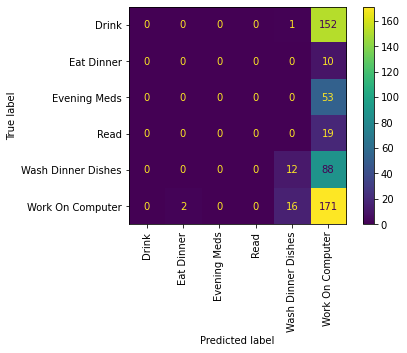

In [10]:
# import
data = pd.read_csv('Features.csv')
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = train_test_by_label(data)
# turn into ndarrays for tf
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# introductory model as per specifications
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
outputs = keras.layers.Dense(300, activation="linear", kernel_regularizer='l2', name="predictions")(inputs)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.SGD(), loss='mse')
model.fit(X_train, emb_train, epochs=15, verbose=2, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# normalize

Number of words  : 2707
Number of words  : 524
Epoch 1/15
85/85 - 0s - loss: 0.3263
Epoch 2/15
85/85 - 0s - loss: 0.3159
Epoch 3/15
85/85 - 0s - loss: 0.3059
Epoch 4/15
85/85 - 0s - loss: 0.2963
Epoch 5/15
85/85 - 0s - loss: 0.2869
Epoch 6/15
85/85 - 0s - loss: 0.2779
Epoch 7/15
85/85 - 0s - loss: 0.2692
Epoch 8/15
85/85 - 0s - loss: 0.2608
Epoch 9/15
85/85 - 0s - loss: 0.2526
Epoch 10/15
85/85 - 0s - loss: 0.2448
Epoch 11/15
85/85 - 0s - loss: 0.2372
Epoch 12/15
85/85 - 0s - loss: 0.2298
Epoch 13/15
85/85 - 0s - loss: 0.2228
Epoch 14/15
85/85 - 0s - loss: 0.2159
Epoch 15/15
85/85 - 0s - loss: 0.2093

Evaluation:
17/17 [==============================] - 0s 1ms/step - loss: 0.2079

Model accuracy is: 
 0.3606870229007634

Model precision is: 
 0.8934478371501272

Model recall is: 
 0.16666666666666666

Model F1 measure is: 
 0.08835904628330994

Confusion Matrix:



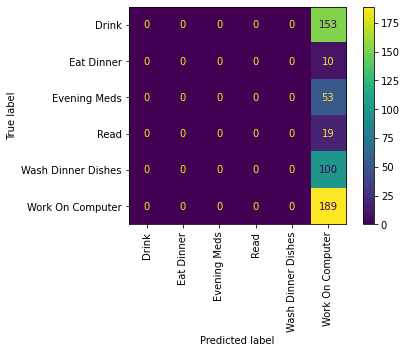

In [11]:
# import
data = pd.read_csv('Features.csv')
# remove empty cols
data = data[data.columns[data.max() != 0]]
# save Activity column
Activities = data['Activity']
# normalize
data = sklearn.preprocessing.normalize(data.iloc[:, 1:])
# insert back Activity
data = pd.DataFrame(data)
data.insert(0, 'Activity', Activities)
# split
X_train, y_train, X_test, y_test = train_test_by_label(data)
# turn into ndarrays for tf
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# introductory model as per specifications
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
outputs = keras.layers.Dense(300, activation="linear", kernel_regularizer='l2', name="predictions")(inputs)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.SGD(), loss='mse')
model.fit(X_train, emb_train, epochs=15, verbose=2, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# let's only use test classes that are similar to what is in the training set

Number of words  : 2891
Number of words  : 340
Epoch 1/15
91/91 - 0s - loss: 0.3353
Epoch 2/15
91/91 - 0s - loss: 0.3239
Epoch 3/15
91/91 - 0s - loss: 0.3130
Epoch 4/15
91/91 - 0s - loss: 0.3025
Epoch 5/15
91/91 - 0s - loss: 0.2923
Epoch 6/15
91/91 - 0s - loss: 0.2825
Epoch 7/15
91/91 - 0s - loss: 0.2731
Epoch 8/15
91/91 - 0s - loss: 0.2640
Epoch 9/15
91/91 - 0s - loss: 0.2552
Epoch 10/15
91/91 - 0s - loss: 0.2468
Epoch 11/15
91/91 - 0s - loss: 0.2387
Epoch 12/15
91/91 - 0s - loss: 0.2308
Epoch 13/15
91/91 - 0s - loss: 0.2233
Epoch 14/15
91/91 - 0s - loss: 0.2160
Epoch 15/15
91/91 - 0s - loss: 0.2090

Evaluation:
11/11 [==============================] - 0s 280us/step - loss: 0.1966

Model accuracy is: 
 0.47941176470588237

Model precision is: 
 0.7686274509803921

Model recall is: 
 0.45441595441595445

Model F1 measure is: 
 0.3337946096566786

Confusion Matrix:



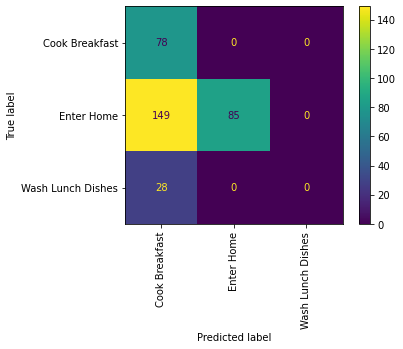

In [12]:
# import
data = pd.read_csv('Features.csv')
# remove empty cols
data = data[data.columns[data.max() != 0]]
# save Activity column
Activities = data['Activity']
# normalize
data = sklearn.preprocessing.normalize(data.iloc[:, 1:])
# insert back Activity
data = pd.DataFrame(data)
data.insert(0, 'Activity', Activities)
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Breakfast', 'Enter Home', 'Wash Lunch Dishes'])
# turn into ndarrays for tf
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# introductory model as per specifications
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
outputs = keras.layers.Dense(300, activation="linear", kernel_regularizer='l2', name="predictions")(inputs)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.SGD(), loss='mse')
model.fit(X_train, emb_train, epochs=15, verbose=2, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# Let's introduce more complexity in the model

Number of words  : 2891
Number of words  : 340
Epoch 1/3
723/723 [==============================] - 5s 5ms/step - loss: 1.7501
Epoch 2/3
723/723 [==============================] - 4s 5ms/step - loss: 0.0354
Epoch 3/3
723/723 [==============================] - 4s 5ms/step - loss: 0.0456

Evaluation:
11/11 [==============================] - 0s 2ms/step - loss: 0.1552

Model accuracy is: 
 0.2411764705882353

Model precision is: 
 0.357300483914188

Model recall is: 
 0.23656898656898653

Model F1 measure is: 
 0.23011319958009932

Confusion Matrix:



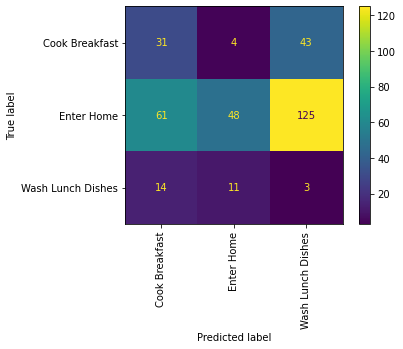

In [13]:
# import
data = pd.read_csv('Features.csv')
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Breakfast', 'Enter Home', 'Wash Lunch Dishes'])
# normalize
X_train = sklearn.preprocessing.scale(X_train)
X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
# X_train = X_train.values # it already is
y_train = y_train.values
# X_test = X_test.values # it already is
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="relu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="relu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="relu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="relu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="relu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=3, batch_size=4, verbose=1)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# classes are heavily imbalanced and some are very small. Let's oversample.

Number of words  : 7998
Number of words  : 774
Epoch 1/12
500/500 [==============================] - 5s 6ms/step - loss: 1.3769
Epoch 2/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0226
Epoch 3/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0235
Epoch 4/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0256
Epoch 5/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0256
Epoch 6/12
500/500 [==============================] - 3s 7ms/step - loss: 0.0251
Epoch 7/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0233
Epoch 8/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0221
Epoch 9/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0209
Epoch 10/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0193
Epoch 11/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0185
Epoch 12/12
500/500 [==============================] - 3s 6m

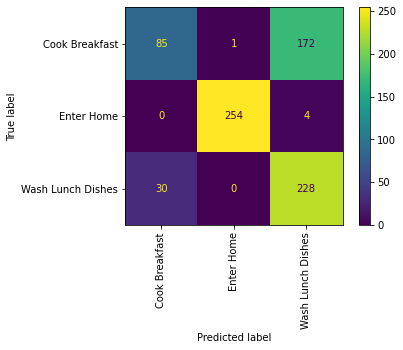

In [14]:
# import
data = pd.read_csv('Features.csv')
# oversample
sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Breakfast', 'Enter Home', 'Wash Lunch Dishes'])
# normalize
X_train = sklearn.preprocessing.scale(X_train)
X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
# X_train = X_train.values # it already is
y_train = y_train.values
# X_test = X_test.values # it already is
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="relu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="relu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="relu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="relu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="relu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=16, verbose=1)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# we are getting somewhere. 'Cook Breakfast' and 'Wash Lunch Dishes' could be too similar to tell apart consistently

In [15]:
# launch a few times to get a 'taste' of the distribution
CB = data.loc[data['Activity'] == 'Cook Breakfast'].sample(1).iloc[:, 1:]
EH = data.loc[data['Activity'] == 'Enter Home'].sample(1).iloc[:, 1:]
WLD = data.loc[data['Activity'] == 'Wash Lunch Dishes'].sample(1).iloc[:, 1:]
CB
print(
    sklearn.metrics.pairwise.euclidean_distances(CB, EH),
    sklearn.metrics.pairwise.euclidean_distances(CB, WLD)
)

[[27.85677655]] [[10.44030651]]


# apparently, what happens is that the feature sets are too similar between different activities. Most of the time, the patterns are sufficiently different, but not consistently enough to obtain good predictions. One solution could be to forget the number of activations and simply consider which sensors get activated. But first, this could just be the result of oversampling, let's check if it happens with original data.

In [16]:
# import
data = pd.read_csv('Features.csv')
# launch a few times to get a 'taste' of the distribution
CB = data.loc[data['Activity'] == 'Cook Breakfast'].sample(1).iloc[:, 1:]
EH = data.loc[data['Activity'] == 'Enter Home'].sample(1).iloc[:, 1:]
WLD = data.loc[data['Activity'] == 'Wash Lunch Dishes'].sample(1).iloc[:, 1:]
CB
print(
    sklearn.metrics.pairwise.euclidean_distances(CB, EH),
    sklearn.metrics.pairwise.euclidean_distances(CB, WLD),
    sklearn.metrics.pairwise.euclidean_distances(EH, WLD)
)

[[28.31960452]] [[22.56102835]] [[6.40312424]]


# it does, then the solution mentioned above makes sense. But before trying that, we check if by setting other words the neural network picks up the classes, it may be able to see patterns hidden from me. After all, it was able to distinguish enter home from the other two.

Number of words  : 7998
Number of words  : 774
Epoch 1/12
500/500 [==============================] - 4s 6ms/step - loss: 1.3745
Epoch 2/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0227
Epoch 3/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0235
Epoch 4/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0248
Epoch 5/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0249
Epoch 6/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0238
Epoch 7/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0228
Epoch 8/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0218
Epoch 9/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0202
Epoch 10/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0189
Epoch 11/12
500/500 [==============================] - 3s 6ms/step - loss: 0.0181
Epoch 12/12
500/500 [==============================] - 3s 6m

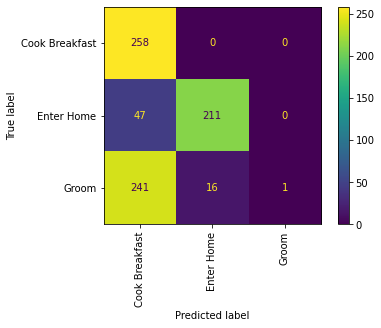

In [17]:
# import
data = pd.read_csv('Features.csv')
# oversample
sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Breakfast', 'Enter Home', 'Groom'])
# normalize
X_train = sklearn.preprocessing.scale(X_train)
X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
# X_train = X_train.values # it already is
y_train = y_train.values
# X_test = X_test.values # it already is
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="relu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="relu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="relu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="relu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="relu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=16, verbose=1)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# Good but not enough. Let's set every sensor to 1 if it gets activated at least once and 0 otherwise.

Number of words  : 7740
Number of words  : 1032
Epoch 1/12
968/968 [==============================] - 8s 6ms/step - loss: 1.1856
Epoch 2/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0300
Epoch 3/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0317
Epoch 4/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0283
Epoch 5/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0231
Epoch 6/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0207
Epoch 7/12
968/968 [==============================] - 5s 6ms/step - loss: 0.0190
Epoch 8/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0184
Epoch 9/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0183
Epoch 10/12
968/968 [==============================] - 5s 6ms/step - loss: 0.0182
Epoch 11/12
968/968 [==============================] - 5s 6ms/step - loss: 0.0174
Epoch 12/12
968/968 [==============================] - 5s 6

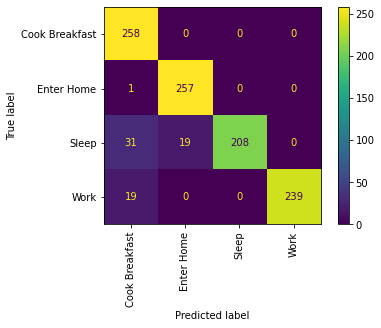

In [18]:
# import
data = pd.read_csv('Features.csv')
# every non-zero value becomes 1
for name in list(data.columns):
    if is_numeric_dtype(data[name]):
        data[name] /= data[name]
data = data.fillna(0)
# oversample
sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Breakfast', 'Enter Home', 'Sleep', 'Work'])
# this time we don't normalize since we have binary data
#X_train = sklearn.preprocessing.scale(X_train)
#X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="relu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="relu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="relu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="relu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="relu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=8, verbose=1, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# this was good, is it consistent?

Number of words  : 7740
Number of words  : 1032
Epoch 1/12
968/968 [==============================] - 7s 6ms/step - loss: 1.1569
Epoch 2/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0302
Epoch 3/12
968/968 [==============================] - 5s 6ms/step - loss: 0.0322
Epoch 4/12
968/968 [==============================] - 5s 6ms/step - loss: 0.0271
Epoch 5/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0236
Epoch 6/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0203
Epoch 7/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0187
Epoch 8/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0184
Epoch 9/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0181
Epoch 10/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0177
Epoch 11/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0175
Epoch 12/12
968/968 [==============================] - 6s 6

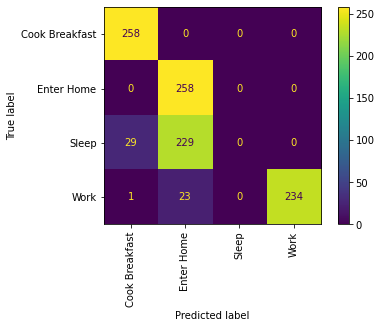

In [19]:
# import
data = pd.read_csv('Features.csv')
# every non-zero value becomes 1
for name in list(data.columns):
    if is_numeric_dtype(data[name]):
        data[name] /= data[name]
data = data.fillna(0)
# oversample
sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Breakfast', 'Enter Home', 'Sleep', 'Work'])
# this time we don't normalize since we have binary data
#X_train = sklearn.preprocessing.scale(X_train)
#X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="relu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="relu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="relu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="relu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="relu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=8, verbose=1, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# it kind of is. great. it appears sleep is not correctly recognized. let's substitute it and check.

Number of words  : 7740
Number of words  : 1032
Epoch 1/12
968/968 [==============================] - 7s 6ms/step - loss: 1.2174
Epoch 2/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0306
Epoch 3/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0344
Epoch 4/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0290
Epoch 5/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0249
Epoch 6/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0216
Epoch 7/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0197
Epoch 8/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0192
Epoch 9/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0189
Epoch 10/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0186
Epoch 11/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0181
Epoch 12/12
968/968 [==============================] - 5s 5

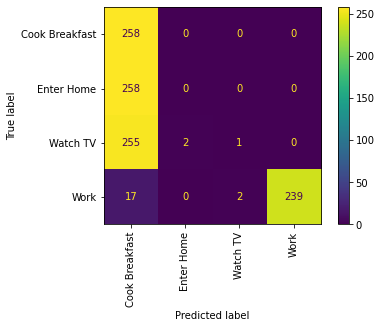

In [20]:
# import
data = pd.read_csv('Features.csv')
# every non-zero value becomes 1
for name in list(data.columns):
    if is_numeric_dtype(data[name]):
        data[name] /= data[name]
data = data.fillna(0)
# oversample
sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Breakfast', 'Enter Home', 'Watch TV', 'Work'])
# this time we don't normalize since we have binary data
#X_train = sklearn.preprocessing.scale(X_train)
#X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="relu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="relu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="relu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="relu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="relu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=8, verbose=1, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# it's hard to find a 4th word that works well. Let's remove it and keep the 3 that give good results.

Number of words  : 7998
Number of words  : 774
Epoch 1/12
1000/1000 [==============================] - 7s 6ms/step - loss: 1.1805
Epoch 2/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0297
Epoch 3/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0338
Epoch 4/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0279
Epoch 5/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0239
Epoch 6/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0210
Epoch 7/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0200
Epoch 8/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0190
Epoch 9/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0188
Epoch 10/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0183
Epoch 11/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0177
Epoch 12/12
1000/1000 [===============

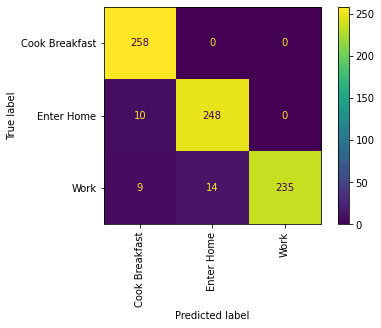

In [21]:
# import
data = pd.read_csv('Features.csv')
# every non-zero value becomes 1
for name in list(data.columns):
    if is_numeric_dtype(data[name]):
        data[name] /= data[name]
data = data.fillna(0)
# oversample
sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Breakfast', 'Enter Home', 'Work'])
# this time we don't normalize since we have binary data
#X_train = sklearn.preprocessing.scale(X_train)
#X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="relu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="relu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="relu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="relu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="relu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=8, verbose=1, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# These words get recognized. Let's try a different approach to improve reliability: find words that have in common a good representation and also highly represented similar words in the training set, then they may not need the oversampling, which can cause noisy data.

Number of words  : 2545
Number of words  : 686
Epoch 1/12
319/319 [==============================] - 3s 6ms/step - loss: 2.4969
Epoch 2/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0232
Epoch 3/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0260
Epoch 4/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0273
Epoch 5/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0309
Epoch 6/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0324
Epoch 7/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0325
Epoch 8/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0331
Epoch 9/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0293
Epoch 10/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0286
Epoch 11/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0256
Epoch 12/12
319/319 [==============================] - 2s 6m

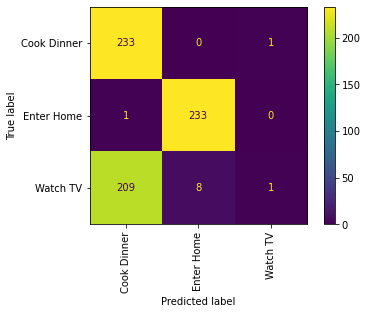

In [22]:
# import
data = pd.read_csv('Features.csv')
# every non-zero value becomes 1
for name in list(data.columns):
    if is_numeric_dtype(data[name]):
        data[name] /= data[name]
data = data.fillna(0)
# oversample
#sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
#X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
#data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Dinner', 'Enter Home', 'Watch TV'])
# this time we don't normalize since we have binary data
#X_train = sklearn.preprocessing.scale(X_train)
#X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="relu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="relu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="relu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="relu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="relu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=8, verbose=1, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# maybe we can even do without the binarization.

Number of words  : 2545
Number of words  : 686
Epoch 1/12
319/319 [==============================] - 3s 6ms/step - loss: 2.2130
Epoch 2/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0252
Epoch 3/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0273
Epoch 4/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0286
Epoch 5/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0295
Epoch 6/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0315
Epoch 7/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0306
Epoch 8/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0321
Epoch 9/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0277
Epoch 10/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0282
Epoch 11/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0261
Epoch 12/12
319/319 [==============================] - 2s 6m

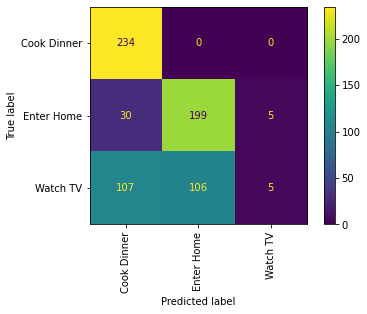

In [23]:
# import
data = pd.read_csv('Features.csv')
# every non-zero value becomes 1
#for name in list(data.columns):
#    if is_numeric_dtype(data[name]):
#        data[name] /= data[name]
#data = data.fillna(0)
# oversample
#sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
#X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
#data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Dinner', 'Enter Home', 'Watch TV'])
# normalize
X_train = sklearn.preprocessing.scale(X_train)
X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
#X_train = X_train.values # it already is 
y_train = y_train.values
# X_test = X_test.values # it already is
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="relu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="relu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="relu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="relu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="relu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=8, verbose=1, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# maybe oversampling without binarization.

Number of words  : 7998
Number of words  : 774
Epoch 1/12
1000/1000 [==============================] - 7s 5ms/step - loss: 1.0338
Epoch 2/12
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0322
Epoch 3/12
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0317
Epoch 4/12
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0283
Epoch 5/12
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0237
Epoch 6/12
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0213
Epoch 7/12
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0199
Epoch 8/12
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0194
Epoch 9/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0191
Epoch 10/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0187
Epoch 11/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0181
Epoch 12/12
1000/1000 [===============

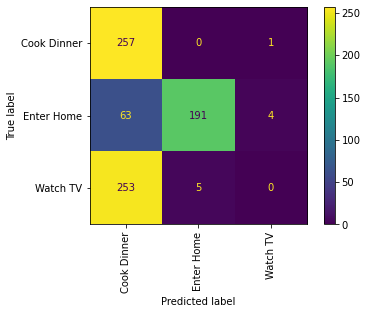

In [24]:
# import
data = pd.read_csv('Features.csv')
# every non-zero value becomes 1
#for name in list(data.columns):
#    if is_numeric_dtype(data[name]):
#        data[name] /= data[name]
#data = data.fillna(0)
# oversample
sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Dinner', 'Enter Home', 'Watch TV'])
# normalize
X_train = sklearn.preprocessing.scale(X_train)
X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
#X_train = X_train.values # it already is 
y_train = y_train.values
# X_test = X_test.values # it already is
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="relu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="relu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="relu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="relu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="relu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=8, verbose=1, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# let's tweak the parameters

Number of words  : 2545
Number of words  : 686
Epoch 1/12
319/319 [==============================] - 4s 7ms/step - loss: 2.0383
Epoch 2/12
319/319 [==============================] - 2s 7ms/step - loss: 0.0257
Epoch 3/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0267
Epoch 4/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0284
Epoch 5/12
319/319 [==============================] - 2s 5ms/step - loss: 0.0303
Epoch 6/12
319/319 [==============================] - 2s 5ms/step - loss: 0.0288
Epoch 7/12
319/319 [==============================] - 2s 5ms/step - loss: 0.0274
Epoch 8/12
319/319 [==============================] - 2s 5ms/step - loss: 0.0243
Epoch 9/12
319/319 [==============================] - 2s 5ms/step - loss: 0.0242
Epoch 10/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0225
Epoch 11/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0202
Epoch 12/12
319/319 [==============================] - 2s 6m

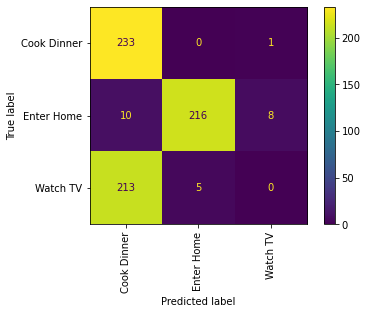

In [25]:
# import
data = pd.read_csv('Features.csv')
# every non-zero value becomes 1
#for name in list(data.columns):
#    if is_numeric_dtype(data[name]):
#        data[name] /= data[name]
#data = data.fillna(0)
# oversample
#sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
#X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
#data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Dinner', 'Enter Home', 'Watch TV'])
# normalize
X_train = sklearn.preprocessing.scale(X_train)
X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
#X_train = X_train.values # it already is 
y_train = y_train.values
# X_test = X_test.values # it already is
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="elu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="elu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="elu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="elu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="elu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="elu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="elu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=8, verbose=1, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# the elu activation improves a bit the predictions. Maybe the network needs the negative side of the spectrum?

Number of words  : 2545
Number of words  : 686
Epoch 1/12
319/319 [==============================] - 5s 7ms/step - loss: 2.0797
Epoch 2/12
319/319 [==============================] - 2s 7ms/step - loss: 0.0246
Epoch 3/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0267
Epoch 4/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0291
Epoch 5/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0284
Epoch 6/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0317
Epoch 7/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0291
Epoch 8/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0290
Epoch 9/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0289
Epoch 10/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0257
Epoch 11/12
319/319 [==============================] - 2s 6ms/step - loss: 0.0238
Epoch 12/12
319/319 [==============================] - 2s 6m

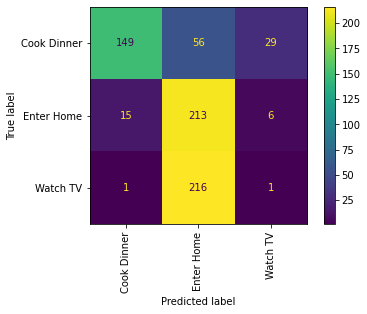

In [26]:
# import
data = pd.read_csv('Features.csv')
# every non-zero value becomes 1
#for name in list(data.columns):
#    if is_numeric_dtype(data[name]):
#        data[name] /= data[name]
#data = data.fillna(0)
# oversample
#sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
#X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
#data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Dinner', 'Enter Home', 'Watch TV'])
# normalize
X_train = sklearn.preprocessing.scale(X_train)
X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
#X_train = X_train.values # it already is 
y_train = y_train.values
# X_test = X_test.values # it already is
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# custom activation function
def activation(x):
    return tf.keras.activations.relu(x, alpha=0.1, max_value=None, threshold=0) # leaky ReLU
# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation=activation, name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation=activation, name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation=activation, name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation=activation, name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation=activation, name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation=activation, name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation=activation, name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=8, verbose=1, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# let's circle back to the solution that worked and implement ELU.

Number of words  : 7998
Number of words  : 774
Epoch 1/12
1000/1000 [==============================] - 8s 6ms/step - loss: 0.9525
Epoch 2/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0295
Epoch 3/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0276
Epoch 4/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0224
Epoch 5/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0192
Epoch 6/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0185
Epoch 7/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0182
Epoch 8/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0182
Epoch 9/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0179
Epoch 10/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0174
Epoch 11/12
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0174
Epoch 12/12
1000/1000 [===============

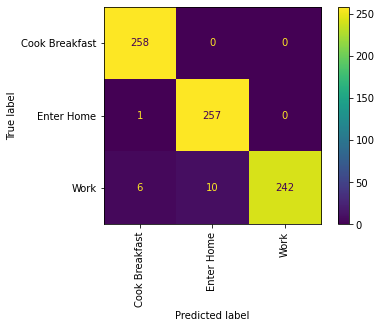

In [27]:
# import
data = pd.read_csv('Features.csv')
# every non-zero value becomes 1
for name in list(data.columns):
    if is_numeric_dtype(data[name]):
        data[name] /= data[name]
data = data.fillna(0)
# oversample
sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Breakfast', 'Enter Home', 'Work'])
# this time we don't normalize since we have binary data
#X_train = sklearn.preprocessing.scale(X_train)
#X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="elu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="elu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="elu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="elu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="elu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="elu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="elu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=8, verbose=1, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# we're getting great predictions on these words. The final goal would be to be able to predict more of them, but there aren't many candidates with the required requisite of a good representation in the training set.

Number of words  : 7740
Number of words  : 1032
Epoch 1/12
968/968 [==============================] - 8s 6ms/step - loss: 0.9908
Epoch 2/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0287
Epoch 3/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0288
Epoch 4/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0233
Epoch 5/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0198
Epoch 6/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0186
Epoch 7/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0186
Epoch 8/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0185
Epoch 9/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0179
Epoch 10/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0174
Epoch 11/12
968/968 [==============================] - 6s 6ms/step - loss: 0.0176
Epoch 12/12
968/968 [==============================] - 6s 6

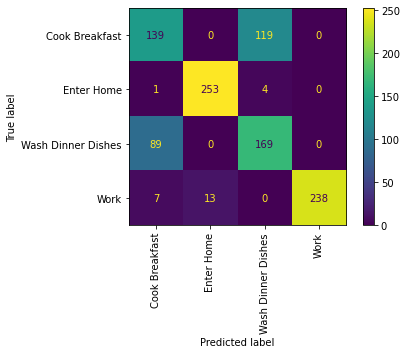

In [28]:
# import
data = pd.read_csv('Features.csv')
# every non-zero value becomes 1
for name in list(data.columns):
    if is_numeric_dtype(data[name]):
        data[name] /= data[name]
data = data.fillna(0)
# oversample
sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = pick_test_classes(data, ['Cook Breakfast', 'Enter Home', 'Wash Dinner Dishes', 'Work'])
# this time we don't normalize since we have binary data
#X_train = sklearn.preprocessing.scale(X_train)
#X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="elu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="elu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="elu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="elu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="elu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="elu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="elu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=8, verbose=1, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# Great. The network has some difficulties discerning between 'Cook Breakfast' and 'Wash Dinner Dishes' likely because these have a very similar feature distribution, as can be seen from code cell 9. Accounting for this, it's totally capable of classifying 'easy' words, which considering the task is already a satisfying result. I wonder how it could perform on a randomly picked test set.

Number of words  : 7224
Number of words  : 1548
Epoch 1/12
903/903 [==============================] - 7s 5ms/step - loss: 1.0237
Epoch 2/12
903/903 [==============================] - 5s 5ms/step - loss: 0.0259
Epoch 3/12
903/903 [==============================] - 5s 5ms/step - loss: 0.0258
Epoch 4/12
903/903 [==============================] - 5s 5ms/step - loss: 0.0218
Epoch 5/12
903/903 [==============================] - 5s 6ms/step - loss: 0.0187
Epoch 6/12
903/903 [==============================] - 5s 5ms/step - loss: 0.0170
Epoch 7/12
903/903 [==============================] - 5s 5ms/step - loss: 0.0167
Epoch 8/12
903/903 [==============================] - 5s 5ms/step - loss: 0.0170
Epoch 9/12
903/903 [==============================] - 5s 5ms/step - loss: 0.0166
Epoch 10/12
903/903 [==============================] - 5s 5ms/step - loss: 0.0162
Epoch 11/12
903/903 [==============================] - 5s 5ms/step - loss: 0.0159
Epoch 12/12
903/903 [==============================] - 5s 6

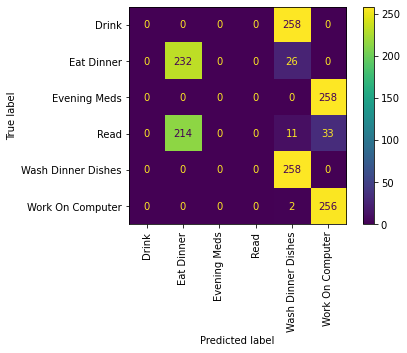

In [29]:
# import
data = pd.read_csv('Features.csv')
# every non-zero value becomes 1
for name in list(data.columns):
    if is_numeric_dtype(data[name]):
        data[name] /= data[name]
data = data.fillna(0)
# oversample
sm = SMOTE(sampling_strategy='auto', k_neighbors=1)
X_oversampled, y_oversampled = sm.fit_resample(data.iloc[:, 1:], data['Activity'])
data = pd.DataFrame(y_oversampled).merge(pd.DataFrame(X_oversampled), left_index=True, right_index=True)
# remove empty cols
data = data[data.columns[data.max() != 0]]
# split
X_train, y_train, X_test, y_test = train_test_by_label(data)
# this time we don't normalize since we have binary data
#X_train = sklearn.preprocessing.scale(X_train)
#X_test = sklearn.preprocessing.scale(X_test)
# turn into ndarrays for tf
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
# embed labels
emb_train = np.array(embedder.generate_word2vec(y_train))
emb_test = np.array(embedder.generate_word2vec(y_test))
# unique labels embedding
emb_unique = np.unique(emb_test, axis=0)

# developed model
inputs = keras.Input(shape=(X_train.shape[1],), name="sensors")
x = keras.layers.Dense(16, activation="elu", name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="elu", name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="elu", name="dense_3")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="elu", name="dense_4")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="elu", name="dense_5")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation="elu", name="dense_6")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation="elu", name="dense_7")(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(300, kernel_regularizer='l2', name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='mse')
model.fit(X_train, emb_train, epochs=12, batch_size=8, verbose=1, shuffle=True)

print('\nEvaluation:')
model.evaluate(X_test, emb_test)
predictions = model.predict(X_test)
closest_embedded = closest_to_predictions(predictions, emb_unique)
closest_reversed = reverse_embedding(y_test, emb_test, closest_embedded)
model_evaluation(y_test, closest_reversed)

# undestandably, the network only recognizes words with good representation in the training set. Interestingly though, it is not bothered by the presence of noise words, those that aren't correctly predicted: it is still able to pick the 'easy' ones from the others and from each other, and classifies the other ones with great confidence and variety (not all the wrong predictions are attributed to the same class). This is not trivial, as it means that not only the network picks up on the distributions of data, but also that the different words have a significantly different pattern that the network can identify even when it is not able to correctly classify them. This combined with the amount of noise that oversampling introduces, crucially means that with a greater amount of data and variety of activities, this model shows great promise in achieving the original goal.